Student Name: Naif Alqahtani

ID: 202172110

Section: 1

Team: 9

# ICS474 Assignment 1: Apache Spark in a Cloud Environment  
## Dataset: Company Employees Information (Multi-table)

I chose Apache Spark as my tool to demonstrate its data-processing capabilities in a cloud-based environment. In this notebook, I perform a complete data-engineering workflow with the goal of showcasing Spark’s strengths in scalable data processing, analytics, and performance optimization.

The data used is the Company Employees Information Dataset, which consists of multiple related CSV files:

- `employees.csv` — Core demographic and organizational attributes  
- `departments.csv` — Department names and categories  
- `locations.csv` — Global office locations with cost-of-living indices  
- `promotions.csv` — Career progression events over time  
- `salaries_annual.csv` — Yearly compensation history (2014–2025)  
- `org_edges.csv` — Manager–employee relationships for org chart visualization  

It was generated entirely using the Faker library and structured to mirror realistic corporate data. This dataset is ideal for demonstrating both basic and advanced Spark operations, including:

- Data extraction and ingestion from multiple sources  
- Data cleaning and feature engineering  
- Joins across related tables  
- Exploratory analysis and aggregations  
- SQL queries and window functions  
- Partitioned storage and predicate pushdown  
- Performance tuning (shuffle partitions, caching)


In [ ]:
# Installs the necessary packages
!pip install -q pyspark kagglehub pandas
!pip install -q pyngrok #We need this to use spark dashboard

In [ ]:
# Start Spark session
# SparkSession is the main entry point to Spark.
# Set shuffle.partitions to a smaller value than default (200)
# because we're on a single Colab machine, not a big cluster.

import pyspark
from pyspark.sql import SparkSession, functions as F

spark = (
    SparkSession.builder
    .appName("ICS474-CompanyEmployees")
    .config("spark.sql.shuffle.partitions", "8")  # we'll play with this later
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

In [ ]:
# Download the multi-table dataset from Kaggle
import kagglehub, os

path = kagglehub.dataset_download("wafaaelhusseini/company-employees-information-dataset")
print("Dataset folder:", path)
print("Files inside:", os.listdir(path))


Using Colab cache for faster access to the 'company-employees-information-dataset' dataset.
Dataset folder: /kaggle/input/company-employees-information-dataset
Files inside: ['locations.csv', 'promotions.csv', 'employees.csv', 'salaries_annual.csv', 'org_edges.csv', 'departments.csv']


In [ ]:
from pyngrok import ngrok, conf

# Kill previous tunnels
ngrok.kill()
conf.get_default().auth_token = "35Tm9IB5N3be1EK3kkzmkNmZH5F_4sjC7LufjMbXsopQcaMXK"

public_url = ngrok.connect(4040).public_url
print("Spark UI URL:", public_url)

Spark UI URL: https://unmown-smirkingly-bradford.ngrok-free.dev


In [ ]:
# Load each CSV as a separate Spark DataFrame
employees_df   = spark.read.csv(f"{path}/employees.csv",       header=True, inferSchema=True)
departments_df = spark.read.csv(f"{path}/departments.csv",     header=True, inferSchema=True)
locations_df   = spark.read.csv(f"{path}/locations.csv",       header=True, inferSchema=True)
promotions_df  = spark.read.csv(f"{path}/promotions.csv",      header=True, inferSchema=True)
salaries_df    = spark.read.csv(f"{path}/salaries_annual.csv", header=True, inferSchema=True)
org_edges_df   = spark.read.csv(f"{path}/org_edges.csv",       header=True, inferSchema=True)

print("employees_df:")
employees_df.show(5, truncate=False)
employees_df.printSchema()

print("salaries_df:")
salaries_df.show(5, truncate=False)
salaries_df.printSchema()


employees_df:
+-----------+---------------+----------+---+-------------+-----------+---------+---------+----------+---------+-----------------+------------------+------------------+----------+
|employee_id|name           |gender    |age|department_id|location_id|seniority|education|hire_date |work_mode|performance_score|satisfaction_score|initial_salary_usd|manager_id|
+-----------+---------------+----------+---+-------------+-----------+---------+---------+----------+---------+-----------------+------------------+------------------+----------+
|1          |Allison Hill   |Male      |34 |21           |4          |Intern   |Bachelor |2020-03-03|On-site  |4.2              |7.6               |39578.39          |2177      |
|2          |Noah Rhodes    |Non-binary|32 |3            |7          |Mid      |Master   |2014-08-06|Hybrid   |3.46             |7.2               |141489.28         |2225      |
|3          |Angie Henderson|Female    |29 |25           |6          |Senior   |Bachelor |2

In [ ]:
# Define key column names
EMP_ID_COL      = "employee_id"
DEPT_ID_COL     = "department_id"
LOC_ID_COL      = "location_id"
MANAGER_ID_COL  = "manager_id"
YEAR_COL        = "year"
SALARY_COL      = "salary_usd"
SENIORITY_COL   = "seniority_level"
COLI_COL        = "cost_index"
DEPT_NAME_COL   = "department"
REGION_COL      = "region"
COUNTRY_COL     = "country"
CITY_COL        = "city"
ORG_MANAGER_COL = "source_manager_id"
ORG_EMP_COL     = "target_employee_id"

We’ll use salaries_annual as the base (one row per employee per year), then join employees, departments, and locations, and later join promotions & org edges.

In [ ]:
# Join salaries with employees, departments, locations

# salaries + employees
emp_year_df = (
    salaries_df.alias("s")
    .join(employees_df.alias("e"), on=EMP_ID_COL, how="left")
)

# add department info
emp_year_df = (
    emp_year_df
    .join(departments_df.alias("d"), on=DEPT_ID_COL, how="left")
)

# add location info
emp_year_df = (
    emp_year_df
    .join(locations_df.alias("l"), on=LOC_ID_COL, how="left")
)

emp_year_df.printSchema()
emp_year_df.show(5, truncate=False)


root
 |-- location_id: integer (nullable = true)
 |-- department_id: integer (nullable = true)
 |-- employee_id: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- seniority_level: string (nullable = true)
 |-- salary_usd: double (nullable = true)
 |-- name: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- seniority: string (nullable = true)
 |-- education: string (nullable = true)
 |-- hire_date: date (nullable = true)
 |-- work_mode: string (nullable = true)
 |-- performance_score: double (nullable = true)
 |-- satisfaction_score: double (nullable = true)
 |-- initial_salary_usd: double (nullable = true)
 |-- manager_id: integer (nullable = true)
 |-- department: string (nullable = true)
 |-- category: string (nullable = true)
 |-- country: string (nullable = true)
 |-- city: string (nullable = true)
 |-- cost_index: double (nullable = true)

+-----------+-------------+-----------+----+---------------+----------+

In [ ]:
# Add Promotions and Org Structure
# ---------------------------------------------------
# This step enriches the main fact table (emp_year_df) with:
# 1) Number of promotions per employee
# 2) Number of direct reports for each manager (team size)
# All column names use your updated key definitions.
# ---------------------------------------------------

from pyspark.sql import functions as F

# Promotions per employee
promos_per_emp = (
    promotions_df
    .groupBy(EMP_ID_COL)
    .agg(F.count("*").alias("num_promotions"))
)

# Join into the main table
emp_year_df = (
    emp_year_df
    .join(promos_per_emp, on=EMP_ID_COL, how="left")
    .fillna({"num_promotions": 0})
)


# Org structure: count number of direct reports per manager
# org_edges_df contains:
#  - source_manager_id  (manager)
#  - target_employee_id (employee)

team_sizes = (
    org_edges_df
    .groupBy(ORG_MANAGER_COL)
    .agg(F.count(ORG_EMP_COL).alias("num_direct_reports"))
)

# Join this with the fact table
# emp_year_df.manager_id corresponds to org_edges_df.source_manager_id

emp_year_df = (
    emp_year_df
    .join(
        team_sizes,
        emp_year_df[MANAGER_ID_COL] == team_sizes[ORG_MANAGER_COL],
        how="left"
    )
    .drop(ORG_MANAGER_COL)  # remove duplicate join column
    .fillna({"num_direct_reports": 0})
)

# Show a sample after enrichment
emp_year_df.select(
    EMP_ID_COL, MANAGER_ID_COL,
    "num_promotions", "num_direct_reports"
).show(10, truncate=False)



+-----------+----------+--------------+------------------+
|employee_id|manager_id|num_promotions|num_direct_reports|
+-----------+----------+--------------+------------------+
|1          |2177      |0             |1                 |
|1          |2177      |0             |1                 |
|1          |2177      |0             |1                 |
|1          |2177      |0             |1                 |
|1          |2177      |0             |1                 |
|1          |2177      |0             |1                 |
|2          |2225      |1             |5                 |
|2          |2225      |1             |5                 |
|2          |2225      |1             |5                 |
|2          |2225      |1             |5                 |
+-----------+----------+--------------+------------------+
only showing top 10 rows



In [ ]:
# Feature Engineering on emp_year_df
# Creates:
#  - salary_band (Low / Medium / High)
#  - salary_adjusted (salary normalized by cost of living)
#  - is_senior (1/0 based on seniority_level)
#  - salary_k (salary in thousands)
#  - experience_years (year - hire year)
#
# This produces a clean and enriched analytical table.

from pyspark.sql import functions as F

emp_year_clean = (
    emp_year_df


    # Fill missing values that may break math ops
    .fillna({
        SALARY_COL: 0,
        COLI_COL: 1.0,   # cost index should not be zero
        "num_promotions": 0,
        "num_direct_reports": 0
    })


    # Salary band classification
    .withColumn(
        "salary_band",
        F.when(F.col(SALARY_COL) < 30000, "Low")
         .when((F.col(SALARY_COL) >= 30000) & (F.col(SALARY_COL) < 80000), "Medium")
         .otherwise("High")
    )


    # Cost-adjusted salary (normalize by cost index)
    .withColumn(
        "salary_adjusted",
        F.col(SALARY_COL) / F.col(COLI_COL)
    )


    # Seniority flag (binary)
    .withColumn(
        "is_senior",
        F.when(F.col(SENIORITY_COL).isin("Senior", "Lead", "Principal"), 1).otherwise(0)
    )


    # Salary in thousands (easier to visualize)
    .withColumn(
        "salary_k",
        F.round(F.col(SALARY_COL) / 1000, 2)
    )


    # Experience years (based on hire_date)
    .withColumn(
        "experience_years",
        F.year(F.col(YEAR_COL).cast("string")) - F.year(F.col("hire_date"))
    )
)


# Cache because we'll use this repeatedly
emp_year_clean = emp_year_clean.cache()

print("Rows in cleaned table:", emp_year_clean.count())
emp_year_clean.show(5, truncate=False)


Rows in cleaned table: 22852
+-----------+-----------+-------------+----+---------------+----------+------------+------+---+---------+---------+----------+---------+-----------------+------------------+------------------+----------+----------+--------+-------+-------+----------+--------------+------------------+-----------+------------------+---------+--------+----------------+
|employee_id|location_id|department_id|year|seniority_level|salary_usd|name        |gender|age|seniority|education|hire_date |work_mode|performance_score|satisfaction_score|initial_salary_usd|manager_id|department|category|country|city   |cost_index|num_promotions|num_direct_reports|salary_band|salary_adjusted   |is_senior|salary_k|experience_years|
+-----------+-----------+-------------+----+---------------+----------+------------+------+---+---------+---------+----------+---------+-----------------+------------------+------------------+----------+----------+--------+-------+-------+----------+--------------+--

# Exploratory Data Analysis (EDA)
Now to extract useful information from the data We’ll compute:

* Average salary by department & year
* Average salary by country
* Salary distribution summary
* Promotions vs salary
* Employee satisfaction vs salary
* Experience vs salary trend
* Salary gap between male/female

In [ ]:
# ---------------------------------------------------
# Average salary (and adjusted salary) by department & year

avg_salary_dept_year = (
    emp_year_clean
    .groupBy(YEAR_COL, DEPT_NAME_COL)
    .agg(
        F.round(F.avg(SALARY_COL), 2).alias("avg_salary_usd"),
        F.round(F.avg("salary_adjusted"), 2).alias("avg_salary_adjusted"),
        F.round(F.avg("num_promotions"), 2).alias("avg_promotions"),
        F.count("*").alias("num_records")
    )
    .orderBy(YEAR_COL, DEPT_NAME_COL)
)

avg_salary_dept_year.show(20, truncate=False)

+----+------------------+--------------+-------------------+--------------+-----------+
|year|department        |avg_salary_usd|avg_salary_adjusted|avg_promotions|num_records|
+----+------------------+--------------+-------------------+--------------+-----------+
|2014|Accounting        |100005.65     |94785.59           |0.89          |9          |
|2014|Administration    |70947.27      |81399.1            |0.5           |6          |
|2014|Content Marketing |93056.84      |91566.35           |1.44          |9          |
|2014|Customer Success  |82467.84      |89832.18           |0.82          |11         |
|2014|Customer Support  |58541.75      |65517.02           |0.89          |9          |
|2014|Data Engineering  |159133.05     |156068.96          |1.08          |13         |
|2014|Data Science      |121532.82     |118197.91          |2.25          |8          |
|2014|Design            |130027.47     |127243.59          |1.25          |8          |
|2014|Engineering       |150978.

In [ ]:
# ---------------------------------------------------
# Salary differences across countries

avg_salary_country = (
    emp_year_clean
    .groupBy(COUNTRY_COL)
    .agg(
        F.round(F.avg(SALARY_COL), 2).alias("avg_salary_usd"),
        F.round(F.avg("salary_adjusted"), 2).alias("avg_salary_adj"),
        F.count("*").alias("num_records")
    )
    .orderBy(F.desc("avg_salary_usd"))
)

avg_salary_country.show(truncate=False)

+--------------+--------------+--------------+-----------+
|country       |avg_salary_usd|avg_salary_adj|num_records|
+--------------+--------------+--------------+-----------+
|United States |164600.24     |134019.61     |3438       |
|United Kingdom|163917.96     |131134.37     |1177       |
|Singapore     |155597.69     |127539.09     |1010       |
|Japan         |155125.23     |129271.02     |1081       |
|Netherlands   |154960.58     |134748.33     |916        |
|Canada        |152589.11     |138717.37     |1046       |
|Spain         |147503.49     |140479.52     |1203       |
|Germany       |145707.5      |132461.36     |1100       |
|France        |145363.79     |123189.66     |1058       |
|Australia     |144950.79     |126044.17     |1074       |
|UAE           |140998.53     |134284.31     |1146       |
|Poland        |116493.8      |122625.05     |1021       |
|Mexico        |101601.09     |130257.8      |1039       |
|Brazil        |92284.29      |115355.36     |994       

In [ ]:
# ---------------------------------------------------
# Salary distribution summary

emp_year_clean.select(SALARY_COL).describe().show()

+-------+------------------+
|summary|        salary_usd|
+-------+------------------+
|  count|             22852|
|   mean|130761.75978207609|
| stddev| 79352.52812089212|
|    min|          10100.03|
|    max|         786348.09|
+-------+------------------+



In [ ]:
# ---------------------------------------------------
# Promotions vs salary correlation

promo_vs_salary = (
    emp_year_clean
    .groupBy("num_promotions")
    .agg(
        F.round(F.avg(SALARY_COL), 2).alias("avg_salary"),
        F.count("*").alias("num_records")
    )
    .orderBy("num_promotions")
)

promo_vs_salary.show()

+--------------+----------+-----------+
|num_promotions|avg_salary|num_records|
+--------------+----------+-----------+
|             0| 143277.84|      11305|
|             1| 126489.33|       5807|
|             2| 109124.11|       2957|
|             3| 109149.48|       1567|
|             4| 115272.17|       1216|
+--------------+----------+-----------+



In [ ]:
# ---------------------------------------------------
# Satisfaction vs salary

satisfaction_salary = (
    emp_year_clean
    .groupBy("satisfaction_score")
    .agg(
        F.round(F.avg(SALARY_COL), 2).alias("avg_salary"),
        F.count("*").alias("num_records")
    )
    .orderBy("satisfaction_score")
)

satisfaction_salary.show()

+------------------+----------+-----------+
|satisfaction_score|avg_salary|num_records|
+------------------+----------+-----------+
|               5.0|  138635.7|        208|
|               5.1| 133565.01|        322|
|               5.2| 121599.66|        536|
|               5.3| 137374.47|        423|
|               5.4|  123374.8|        392|
|               5.5| 148198.89|        510|
|               5.6| 127004.75|        468|
|               5.7| 125057.55|        650|
|               5.8| 116192.98|        455|
|               5.9| 122240.96|        512|
|               6.0| 136876.89|        436|
|               6.1| 115113.83|        487|
|               6.2|  131647.1|        598|
|               6.3|  130111.1|        404|
|               6.4| 126125.11|        428|
|               6.5| 131889.92|        433|
|               6.6| 156144.92|        410|
|               6.7| 132908.82|        340|
|               6.8| 132933.13|        520|
|               6.9|  124813.9| 

In [ ]:
# ---------------------------------------------------
# Experience vs salary trend
# Does experience lead to higher salary?

experience_salary = (
    emp_year_clean
    .groupBy("experience_years")
    .agg(
        F.round(F.avg(SALARY_COL), 2).alias("avg_salary"),
        F.count("*").alias("num_records")
    )
    .orderBy("experience_years")
)

experience_salary.show()

+----------------+----------+-----------+
|experience_years|avg_salary|num_records|
+----------------+----------+-----------+
|               0| 111156.16|       3500|
|               1| 115469.01|       3271|
|               2|  119951.5|       2948|
|               3| 125961.18|       2630|
|               4| 131568.74|       2336|
|               5| 137452.72|       2041|
|               6| 143515.57|       1753|
|               7| 150103.37|       1458|
|               8| 156225.32|       1158|
|               9|  164859.5|        867|
|              10| 169722.01|        587|
|              11| 180657.22|        303|
+----------------+----------+-----------+



In [ ]:
# ---------------------------------------------------
# Salary gap by gender

gender_gap = (
    emp_year_clean
    .groupBy("gender")
    .agg(
        F.round(F.avg(SALARY_COL), 2).alias("avg_salary"),
        F.round(F.avg("salary_adjusted"), 2).alias("avg_adjusted_salary"),
        F.count("*").alias("num_records")
    )
    .orderBy("gender")
)

gender_gap.show()

+----------+----------+-------------------+-----------+
|    gender|avg_salary|avg_adjusted_salary|num_records|
+----------+----------+-------------------+-----------+
|    Female| 129475.69|          129922.27|       7641|
|      Male| 131034.76|          130854.12|       7436|
|Non-binary| 131764.56|          132062.18|       7775|
+----------+----------+-------------------+-----------+



# Window Functions (Advanced Spark Analytics)

We’ll calculate:

* Top earners per department per year
* Salary ranking inside departments
* Salary rank inside countries
* Running average salary
* Year-over-year salary change for each employee

In [ ]:
# ---------------------------------------------------
# Top 3 highest-paid employees per department per year

from pyspark.sql.window import Window
import pyspark.sql.functions as F

w_dept_year = Window.partitionBy(YEAR_COL, DEPT_NAME_COL).orderBy(F.desc(SALARY_COL))

top_earners = (
    emp_year_clean
    .withColumn("salary_rank_dept_year", F.rank().over(w_dept_year))
    .filter(F.col("salary_rank_dept_year") <= 3)
    .select(
        YEAR_COL, DEPT_NAME_COL, EMP_ID_COL, "name",
        SALARY_COL, "salary_adjusted", "salary_rank_dept_year"
    )
    .orderBy(YEAR_COL, DEPT_NAME_COL, "salary_rank_dept_year")
)

top_earners.show(50, truncate=False)

+----+-----------------+-----------+-------------------+----------+------------------+---------------------+
|year|department       |employee_id|name               |salary_usd|salary_adjusted   |salary_rank_dept_year|
+----+-----------------+-----------+-------------------+----------+------------------+---------------------+
|2014|Accounting       |204        |Joseph Coleman     |216697.08 |188432.24347826088|1                    |
|2014|Accounting       |1036       |Natalie Malone     |127956.98 |134691.55789473685|2                    |
|2014|Accounting       |2441       |Christopher Mcclure|125655.83 |119672.21904761904|3                    |
|2014|Administration   |1886       |Richard Wood       |106796.86 |92866.8347826087  |1                    |
|2014|Administration   |173        |Joshua Cooke       |96252.97  |101318.91578947369|2                    |
|2014|Administration   |1117       |Jon Clark          |80689.71  |115271.01428571431|3                    |
|2014|Content Marke

In [ ]:
# ---------------------------------------------------
# Salary ranking within each country accross all years

emp_country_salary = (
    emp_year_clean
    .groupBy(EMP_ID_COL, "name", COUNTRY_COL, CITY_COL)
    .agg(F.round(F.avg(SALARY_COL), 2).alias("avg_salary")) # Group all rows for the same employee in the same country/city together
)


w = Window.partitionBy(COUNTRY_COL).orderBy(F.desc("avg_salary")) # treat each country separately

rank_country = (
    emp_country_salary
    .withColumn("salary_rank_country", F.dense_rank().over(w))
    .orderBy(COUNTRY_COL, "salary_rank_country")
)


rank_country.show(20, truncate=False)

+-----------+-------------------+---------+------------+----------+-------------------+
|employee_id|name               |country  |city        |avg_salary|salary_rank_country|
+-----------+-------------------+---------+------------+----------+-------------------+
|2307       |John Francis       |Argentina|Buenos Aires|331519.44 |1                  |
|1375       |William Moon IV    |Argentina|Buenos Aires|236917.1  |2                  |
|2678       |Mr. Kyle Thomas DDS|Argentina|Buenos Aires|227017.14 |3                  |
|218        |Mark Brown         |Argentina|Buenos Aires|207816.01 |4                  |
|3222       |Ross Wallace       |Argentina|Buenos Aires|179683.84 |5                  |
|2825       |Adam Arnold        |Argentina|Buenos Aires|179504.73 |6                  |
|1725       |Sharon Young       |Argentina|Buenos Aires|176214.64 |7                  |
|3053       |Richard Hartman    |Argentina|Buenos Aires|173182.23 |8                  |
|2451       |James Greene       

Take all years of salary data for each employee, calculate their average salary per country, and then rank employees inside each country from
highest to lowest average salary

In [ ]:
# ---------------------------------------------------
# Running average salary for each employee across years

w_employee = Window.partitionBy(EMP_ID_COL).orderBy(YEAR_COL) \
                   .rowsBetween(Window.unboundedPreceding, Window.currentRow)

running_avg_salary = (
    emp_year_clean
    .withColumn("avg_salary_running", F.round(F.avg(SALARY_COL).over(w_employee), 2))
    .select(
        EMP_ID_COL, "name", YEAR_COL, SALARY_COL, "avg_salary_running"
    )
    .orderBy(EMP_ID_COL, YEAR_COL)
)

running_avg_salary.show(20, truncate=False)

+-----------+---------------+----+----------+------------------+
|employee_id|name           |year|salary_usd|avg_salary_running|
+-----------+---------------+----+----------+------------------+
|1          |Allison Hill   |2020|39578.39  |39578.39          |
|1          |Allison Hill   |2021|40637.8   |40108.1           |
|1          |Allison Hill   |2022|42391.87  |40869.35          |
|1          |Allison Hill   |2023|44631.65  |41809.93          |
|1          |Allison Hill   |2024|46574.49  |42762.84          |
|1          |Allison Hill   |2025|49637.37  |43908.6           |
|2          |Noah Rhodes    |2014|141489.28 |141489.28         |
|2          |Noah Rhodes    |2015|144934.51 |143211.9          |
|2          |Noah Rhodes    |2016|149206.63 |145210.14         |
|2          |Noah Rhodes    |2017|153954.28 |147396.18         |
|2          |Noah Rhodes    |2018|157667.62 |149450.46         |
|2          |Noah Rhodes    |2019|162810.16 |151677.08         |
|2          |Noah Rhodes 

In [ ]:
# ---------------------------------------------------
# Year over year salary change for each employee


w_yoy = Window.partitionBy(EMP_ID_COL).orderBy(YEAR_COL)

yoy_salary = (
    emp_year_clean
    .withColumn("prev_year_salary", F.lag(SALARY_COL).over(w_yoy))
    .withColumn(
        "salary_change_yoy",
        F.round(F.col(SALARY_COL) - F.col("prev_year_salary"), 2)
    )
    .select(
        EMP_ID_COL, "name", YEAR_COL, SALARY_COL,
        "prev_year_salary", "salary_change_yoy"
    )
    .orderBy(EMP_ID_COL, YEAR_COL)
)

yoy_salary.show(20, truncate=False)

+-----------+---------------+----+----------+----------------+-----------------+
|employee_id|name           |year|salary_usd|prev_year_salary|salary_change_yoy|
+-----------+---------------+----+----------+----------------+-----------------+
|1          |Allison Hill   |2020|39578.39  |NULL            |NULL             |
|1          |Allison Hill   |2021|40637.8   |39578.39        |1059.41          |
|1          |Allison Hill   |2022|42391.87  |40637.8         |1754.07          |
|1          |Allison Hill   |2023|44631.65  |42391.87        |2239.78          |
|1          |Allison Hill   |2024|46574.49  |44631.65        |1942.84          |
|1          |Allison Hill   |2025|49637.37  |46574.49        |3062.88          |
|2          |Noah Rhodes    |2014|141489.28 |NULL            |NULL             |
|2          |Noah Rhodes    |2015|144934.51 |141489.28       |3445.23          |
|2          |Noah Rhodes    |2016|149206.63 |144934.51       |4272.12          |
|2          |Noah Rhodes    

In [ ]:
# Save as Partitioned Parquet & Test Predicate Pushdown
# We will:
#  1) Write emp_year_clean to disk in Parquet format
#  2) Partition by year (YEAR_COL)
#  3) Compare reading ALL data vs ONLY one year
# This is to show that saving data partitioned
# by year makes reading a filtered subset faster and more efficient.
import time
from pyspark.sql import functions as F

output_path = "/content/emp_year_parquet"

# Overwrite any previous runs
emp_year_clean.write.mode("overwrite").partitionBy(YEAR_COL).parquet(output_path)
print("Written partitioned Parquet to:", output_path)

# ---- Read ALL years (full table scan) ----
t0 = time.time()
full_df = spark.read.parquet(output_path)
full_count = full_df.count()
t1 = time.time()

print(f"Full scan → rows: {full_count}, time: {t1 - t0:.3f} sec")

# ---- Read ONLY one year
filter_year = 2021

t0 = time.time()
subset_df = (
    spark.read.parquet(output_path)
    .filter(F.col(YEAR_COL) == filter_year)
)
subset_count = subset_df.count()
t1 = time.time()

print(f"Filtered scan (year = {filter_year}) → rows: {subset_count}, time: {t1 - t0:.3f} sec")


Written partitioned Parquet to: /content/emp_year_parquet
Full scan → rows: 22852, time: 0.436 sec
Filtered scan (year = 2021) → rows: 2336, time: 0.245 sec


Here I saved the data as Parquet, partitioned by year. When I read only a specific year, Spark uses partition pruning (predicate pushdown) so it skips unnecessary files and reads faster.

In [ ]:
# Performance Tuning (Shuffle Partitions + Caching):
# How changing spark.sql.shuffle.partitions and using cache()
# affects performance of a groupBy aggregation.

# We will:
#  - Change spark.sql.shuffle.partitions (4, 8, 16, 32)
#  - Run a representative aggregation
#  - Compare runtimes with and without caching


from pyspark.sql import functions as F
import time
import pandas as pd

def timed_groupby(shuffle_parts, use_cache=False):
    """
    Runs a representative groupBy aggregation with the given
    shuffle partition setting and optional caching.
    Returns the runtime in seconds.
    """
    spark.conf.set("spark.sql.shuffle.partitions", shuffle_parts)

    df = emp_year_clean
    if use_cache:
        df = df.cache()
        df.count()  # materialize the cache

    t0 = time.time()
    (
        df.groupBy(YEAR_COL, DEPT_NAME_COL)
          .agg(F.avg(SALARY_COL).alias("avg_salary"))
          .count()  # trigger the job
    )
    t1 = time.time()

    if use_cache:
        df.unpersist()

    return round(t1 - t0, 3)

# Run experiments
results = []
for parts in [4, 8, 16, 32]:
    for cached_flag in [False, True]:
        duration = timed_groupby(parts, use_cache=cached_flag)
        results.append((parts, cached_flag, duration))

perf_df = pd.DataFrame(results, columns=["shuffle_partitions", "cached", "duration_sec"])
perf_df

,shuffle_partitions,cached,duration_sec
0,4,False,0.360
1,4,True,0.264
2,8,False,0.688
3,8,True,0.384
4,16,False,0.521
5,16,True,0.200
6,32,False,0.379
7,32,True,0.178


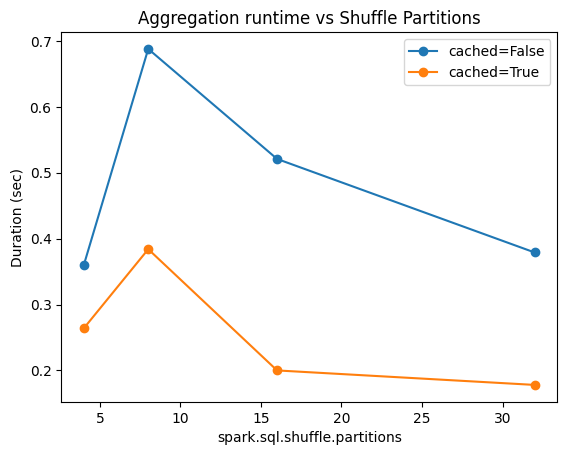

In [ ]:
# Visualiztion
import matplotlib.pyplot as plt

plt.figure()
for cached_flag in [False, True]:
    sub = perf_df[perf_df["cached"] == cached_flag]
    plt.plot(
        sub["shuffle_partitions"],
        sub["duration_sec"],
        marker="o",
        label=f"cached={cached_flag}"
    )

plt.xlabel("spark.sql.shuffle.partitions")
plt.ylabel("Duration (sec)")
plt.title("Aggregation runtime vs Shuffle Partitions")
plt.legend()
plt.show()

Here I’m changing the number of shuffle partitions Spark uses for groupBy. With too few, parallelism is low; with too many, overhead increases. I also compare cached vs non-cached data. We can see how caching reduces runtime when we reuse the same data, and how partition tuning affects performance.

# Conclusion

In this notebook, I used Apache Spark in a cloud environment (Google Colab) to build a complete data-engineering and analytics pipeline on a multi-table company employees dataset.

Key steps included:

- Ingesting multi-table dataset for employees
- Joining them into a unified employee–year fact table
- Performing data cleaning and feature engineering (salary band, cost-adjusted salary, seniority flags, experience, promotions, team size)
- Running analytical queries (salary by department, country, gender, promotions, experience)
- Using advanced Spark window functions (ranking, running average, lag-based year-over-year salary change)
- Saving results as partitioned Parquet and demonstrating predicate pushdown when filtering by year
- Running a performance experiment by changing `spark.sql.shuffle.partitions` and using caching to measure the effect on execution time

These experiments show how Spark can efficiently handle realistic HR data, combine multiple sources, and execute advanced analytics at scale. Even though this demo ran on a single Colab instance, the same Spark code can scale to much larger datasets and clusters with minimal changes.